In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2



In [3]:

# 1️⃣ Transformaciones: redimensionar, normalizar, convertir a tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ajusta tamaño al que usarás en la red
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

# 2️⃣ Cargar datasets
train_data = datasets.ImageFolder(
    root=r"C:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso1.-Detecci-n-de-melanomas\data\train",
    transform=transform
)
test_data = datasets.ImageFolder(
    root=r"C:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso1.-Detecci-n-de-melanomas\data\test",
    transform=transform
)


# 3️⃣ DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 4️⃣ Verificar clases
print("Clases:", train_data.classes)


Clases: ['Benign', 'Malignant']


In [1]:
import torch
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  # NVIDIA GeForce RTX 4060


True
NVIDIA GeForce RTX 4060 Laptop GPU


Usando dispositivo: cuda
Epoch 1/15 | Train Loss: 0.4965 | Val Loss: 0.5189 | Val Acc: 0.7570
Epoch 2/15 | Train Loss: 0.4540 | Val Loss: 0.4883 | Val Acc: 0.7905
Epoch 3/15 | Train Loss: 0.4373 | Val Loss: 0.4859 | Val Acc: 0.7775
Epoch 4/15 | Train Loss: 0.4297 | Val Loss: 0.4696 | Val Acc: 0.7885
Epoch 5/15 | Train Loss: 0.4233 | Val Loss: 0.4510 | Val Acc: 0.8030
Epoch 6/15 | Train Loss: 0.4147 | Val Loss: 0.4408 | Val Acc: 0.7935
Epoch 7/15 | Train Loss: 0.4087 | Val Loss: 0.4082 | Val Acc: 0.8365
Epoch 8/15 | Train Loss: 0.4027 | Val Loss: 0.4081 | Val Acc: 0.8300
Epoch 9/15 | Train Loss: 0.3948 | Val Loss: 0.4127 | Val Acc: 0.8165
Epoch 10/15 | Train Loss: 0.3919 | Val Loss: 0.3782 | Val Acc: 0.8435
Epoch 11/15 | Train Loss: 0.3868 | Val Loss: 0.3807 | Val Acc: 0.8320
Epoch 12/15 | Train Loss: 0.3817 | Val Loss: 0.3712 | Val Acc: 0.8375
Epoch 13/15 | Train Loss: 0.3745 | Val Loss: 0.4036 | Val Acc: 0.8330
Epoch 14/15 | Train Loss: 0.3679 | Val Loss: 0.3506 | Val Acc: 0.8560
Epoc

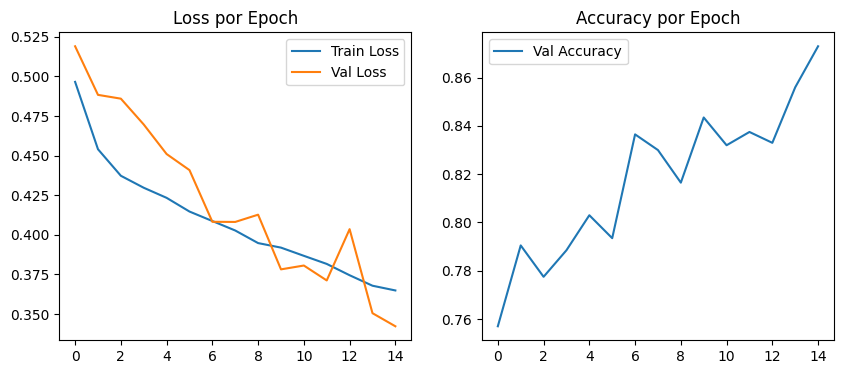

In [5]:
# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

num_epochs = 15
learning_rate = 0.001

# --- CNN ligera ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1,1))  # salida 64x1x1
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, len(train_data.classes))  # 2 clases: benigno/maligno
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# --- Modelo, pérdida y optimizador ---
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Entrenamiento ---
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    val_loss /= len(test_loader.dataset)
    val_acc = correct / len(test_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

# --- Guardar métricas ---
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'model_state': model.state_dict()
}, 'training_metrics_gpu.pth')  # cambiado a gpu

# --- Graficar ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Loss por Epoch')

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend(); plt.title('Accuracy por Epoch')
plt.show()


In [6]:
model.eval()  # modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # la clase con mayor probabilidad
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


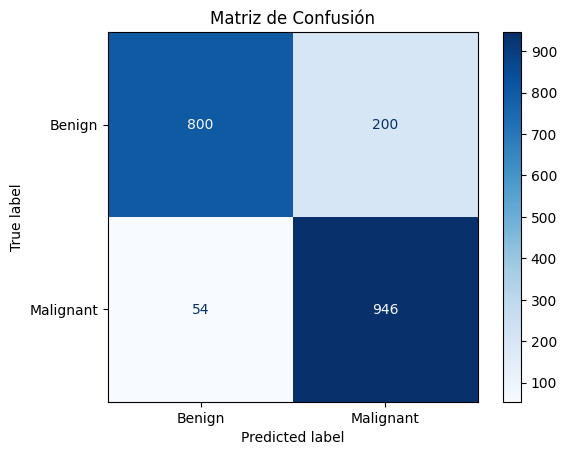

In [9]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()


Usando dispositivo: cuda
Epoch 1/15 | Train Loss: 0.4948 | Val Loss: 0.5296 | Val Acc: 0.7280
Epoch 2/15 | Train Loss: 0.4563 | Val Loss: 0.5078 | Val Acc: 0.7475
Epoch 3/15 | Train Loss: 0.4444 | Val Loss: 0.4891 | Val Acc: 0.7805
Epoch 4/15 | Train Loss: 0.4312 | Val Loss: 0.4544 | Val Acc: 0.8115
Epoch 5/15 | Train Loss: 0.4213 | Val Loss: 0.4888 | Val Acc: 0.7840
Epoch 6/15 | Train Loss: 0.4165 | Val Loss: 0.4316 | Val Acc: 0.8130
Epoch 7/15 | Train Loss: 0.4031 | Val Loss: 0.4214 | Val Acc: 0.8250
Epoch 8/15 | Train Loss: 0.4020 | Val Loss: 0.4252 | Val Acc: 0.8110
Epoch 9/15 | Train Loss: 0.3903 | Val Loss: 0.4012 | Val Acc: 0.8240
Epoch 10/15 | Train Loss: 0.3854 | Val Loss: 0.3897 | Val Acc: 0.8445
Epoch 11/15 | Train Loss: 0.3814 | Val Loss: 0.3706 | Val Acc: 0.8545
Epoch 12/15 | Train Loss: 0.3815 | Val Loss: 0.4010 | Val Acc: 0.8275
Epoch 13/15 | Train Loss: 0.3726 | Val Loss: 0.3756 | Val Acc: 0.8465
Epoch 14/15 | Train Loss: 0.3747 | Val Loss: 0.3612 | Val Acc: 0.8460
Epoc

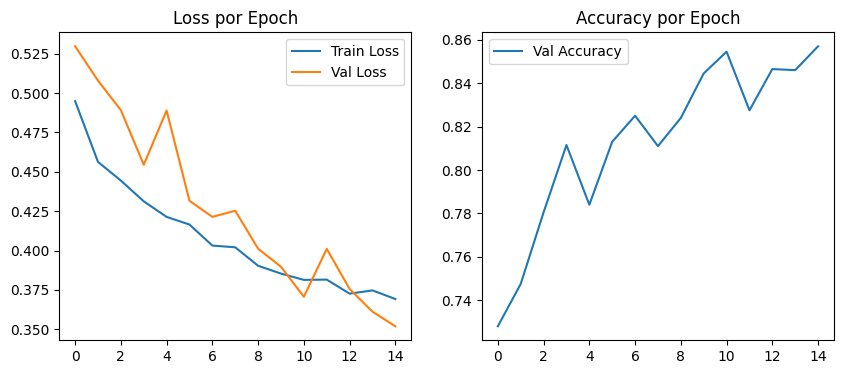

In [14]:
# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

num_epochs = 15
learning_rate = 0.001

# --- Transformación con heatmap ---
def add_heatmap_channel(img):
    """
    img: tensor 3x224x224 (RGB)
    devuelve: tensor 4x224x224 (RGB + heatmap)
    """
    img_np = img.permute(1, 2, 0).numpy()  # HxWxC
    gray = cv2.cvtColor((img_np*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    heatmap = cv2.GaussianBlur(gray, (15, 15), 0)  # suaviza
    heatmap = heatmap / 255.0  # normaliza
    heatmap_tensor = torch.tensor(heatmap).unsqueeze(0)  # 1xHxW
    return torch.cat([img, heatmap_tensor], dim=0)  # 4xHxW

# --- CNN ligera que acepta 4 canales ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(4, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, len(train_data.classes))
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Entrenamiento con heatmap ---
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # agregar canal de heatmap
        images = torch.stack([add_heatmap_channel(img) for img in images])
        images, labels = images.to(device).float(), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = torch.stack([add_heatmap_channel(img) for img in images])
            images = images.float()  # ✅ importante
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    
    val_loss /= len(test_loader.dataset)
    val_acc = correct / len(test_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

# --- Guardar métricas ---
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'model_state': model.state_dict()
}, 'training_metrics_gpu_heatmap.pth')

# --- Graficar ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Loss por Epoch')

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend(); plt.title('Accuracy por Epoch')
plt.show()


In [19]:
model.eval()  # modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = torch.stack([add_heatmap_channel(img) for img in images])
        images = images.float()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # la clase con mayor probabilidad
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


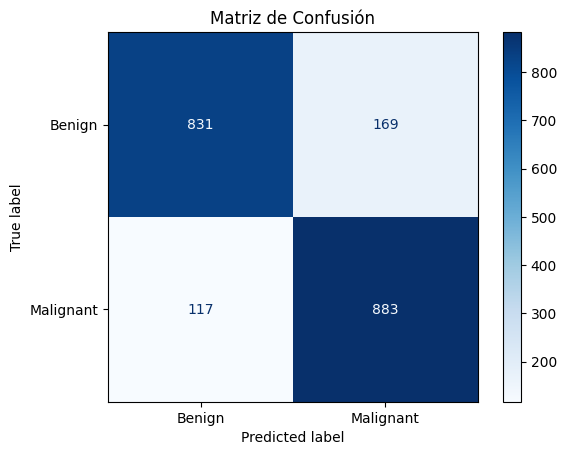

In [20]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()


In [ ]:
# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

num_epochs = 40   # ✅ subido a 40
learning_rate = 0.001
patience = 5      # ✅ early stopping paciencia de 3 epochs
best_val_loss = float("inf")
counter = 0  # contador de epochs sin mejora

# --- Transformación con heatmap ---
def add_heatmap_channel(img):
    """
    img: tensor 3x224x224 (RGB)
    devuelve: tensor 4x224x224 (RGB + heatmap)
    """
    img_np = img.permute(1, 2, 0).numpy()  # HxWxC
    gray = cv2.cvtColor((img_np*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    heatmap = cv2.GaussianBlur(gray, (15, 15), 0)
    heatmap = heatmap / 255.0
    heatmap_tensor = torch.tensor(heatmap).unsqueeze(0)
    return torch.cat([img, heatmap_tensor], dim=0)

# --- CNN ligera que acepta 4 canales ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(4, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, len(train_data.classes))
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Entrenamiento con heatmap ---
train_losses, val_losses, val_accuracies = [], [], []

best_model_state = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = torch.stack([add_heatmap_channel(img) for img in images])
        images, labels = images.to(device).float(), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = torch.stack([add_heatmap_channel(img) for img in images])
            images = images.float()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    
    val_loss /= len(test_loader.dataset)
    val_acc = correct / len(test_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    # --- Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        counter = 0  # resetea paciencia
    else:
        counter += 1
        if counter >= patience:
            print(f"⛔ Early stopping en epoch {epoch+1} (no mejora en {patience} epochs).")
            break

# --- Guardar mejor modelo ---
if best_model_state:
    torch.save({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'model_state': best_model_state
    }, 'best_model_heatmap_2.pth')


Usando dispositivo: cuda


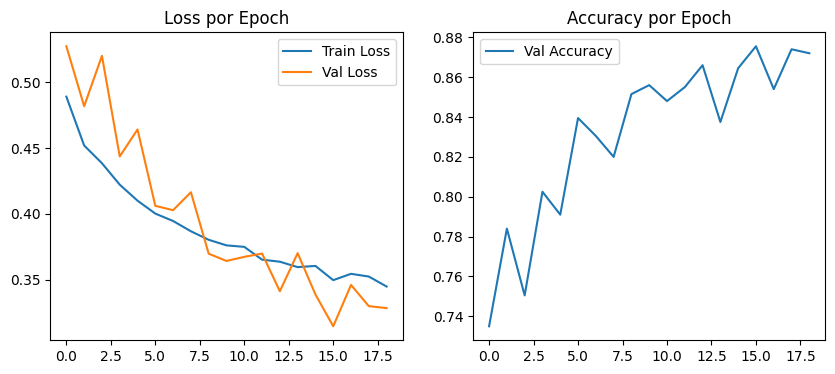

In [22]:

# --- Graficar ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Loss por Epoch')

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend(); plt.title('Accuracy por Epoch')
plt.show()


In [27]:
model.eval()  # modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = torch.stack([add_heatmap_channel(img) for img in images])
        images = images.float()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # la clase con mayor probabilidad
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


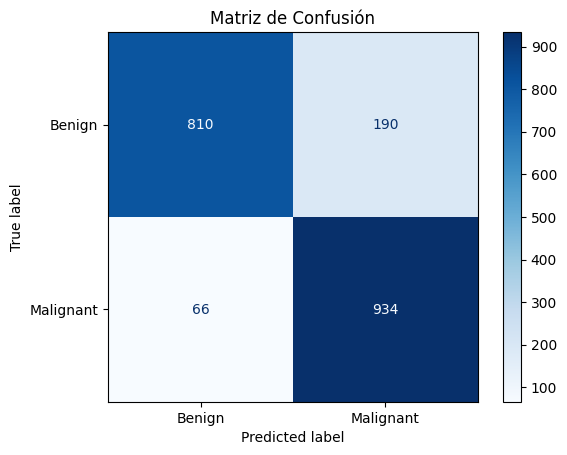

In [28]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()
